# Error Analysis

This notebook performs error analysis comparing predictions from Logistic Regression, TextCNN, and BERT models.

In [1]:
import sys
import os
# Add project root to Python path
project_root = os.path.dirname(os.getcwd())
sys.path.insert(0, project_root)

import numpy as np
import pandas as pd
import joblib
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_utils import load_text_classification_data
from src.text_preprocess import basic_clean
from src.features import build_tfidf_vectorizer
from src.model.text_cnn import TextCNN
from src.model.bert_model import BertClassifier, get_tokenizer
from src.evaluate import evaluate_classification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

ModuleNotFoundError: No module named 'seaborn'

## 1. Load Test Data

In [ ]:
# Load test data
test_texts, test_labels, label2id, id2label = load_text_classification_data('test')
test_texts_clean = [basic_clean(text) for text in test_texts]

print(f"Test samples: {len(test_texts)}")
print(f"Label mapping: {label2id}")

Test samples: 4240
Label mapping: {'high': 0, 'low': 1, 'medium': 2}


## 2. Load Baseline Model (Logistic Regression)

In [ ]:
# Load TF-IDF vectorizer and Logistic Regression model
tfidf_vectorizer = joblib.load('../src/model/tfidf_vectorizer.joblib')
logreg_model = joblib.load('../src/model/baseline_logreg.joblib')

# Get predictions
X_test_tfidf = tfidf_vectorizer.transform(test_texts_clean)
logreg_pred = logreg_model.predict(X_test_tfidf)

print("Logistic Regression predictions obtained")
logreg_results = evaluate_classification(test_labels, logreg_pred)
print(f"Accuracy: {logreg_results['accuracy']:.4f}")
print(f"F1 Macro: {logreg_results['f1_macro']:.4f}")

Logistic Regression predictions obtained
Accuracy: 0.6436
F1 Macro: 0.6363


## 3. Load TextCNN Model

In [ ]:
# Load TextCNN model
checkpoint = torch.load('../src/model/textcnn.pt', map_location=device)
vocab = checkpoint['vocab']
model_config = checkpoint['model_config']

# Recreate model
textcnn_model = TextCNN(**model_config).to(device)
textcnn_model.load_state_dict(checkpoint['model_state_dict'])
textcnn_model.eval()

# Create dataset and dataloader
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=128):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        words = text.split()[:self.max_len]
        tokens = [self.vocab.get(word, self.vocab['<UNK>']) for word in words]
        padded = tokens + [self.vocab['<PAD>']] * (self.max_len - len(tokens))
        return torch.tensor(padded, dtype=torch.long), torch.tensor(label, dtype=torch.long)

test_dataset_cnn = TextDataset(test_texts_clean, test_labels, vocab, max_len=128)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=64, shuffle=False)

# Get predictions
textcnn_pred = []
with torch.no_grad():
    for inputs, _ in test_loader_cnn:
        inputs = inputs.to(device)
        outputs = textcnn_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        textcnn_pred.extend(predicted.cpu().numpy())

textcnn_pred = np.array(textcnn_pred)
print("TextCNN predictions obtained")
textcnn_results = evaluate_classification(test_labels, textcnn_pred)
print(f"Accuracy: {textcnn_results['accuracy']:.4f}")
print(f"F1 Macro: {textcnn_results['f1_macro']:.4f}")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8936\3416289942.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../src/model/textcnn.pt', map_locat

TextCNN predictions obtained
Accuracy: 0.6101
F1 Macro: 0.5477


## 4. Load BERT Model

In [ ]:
# Load BERT model
checkpoint_bert = torch.load('../src/model/bert_finetuned.pt', map_location=device)
model_name = checkpoint_bert.get('model_name', 'distilbert-base-uncased')

# Recreate model
bert_model = BertClassifier(model_name=model_name, num_classes=3).to(device)
bert_model.load_state_dict(checkpoint_bert['model_state_dict'])
bert_model.eval()

# Create dataset and dataloader
tokenizer = get_tokenizer(model_name)

class BertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

test_dataset_bert = BertDataset(test_texts_clean, test_labels, tokenizer, max_length=128)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=16, shuffle=False)

# Get predictions
bert_pred = []
with torch.no_grad():
    for batch in test_loader_bert:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = bert_model(input_ids, attention_mask)
        _, predicted = torch.max(outputs.data, 1)
        bert_pred.extend(predicted.cpu().numpy())

bert_pred = np.array(bert_pred)
print("BERT predictions obtained")
bert_results = evaluate_classification(test_labels, bert_pred)
print(f"Accuracy: {bert_results['accuracy']:.4f}")
print(f"F1 Macro: {bert_results['f1_macro']:.4f}")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8936\2126650434.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_bert = torch.load('../src/model/bert_finetuned.pt

BERT predictions obtained
Accuracy: 0.6156
F1 Macro: 0.5996


## 5. Confusion Matrices

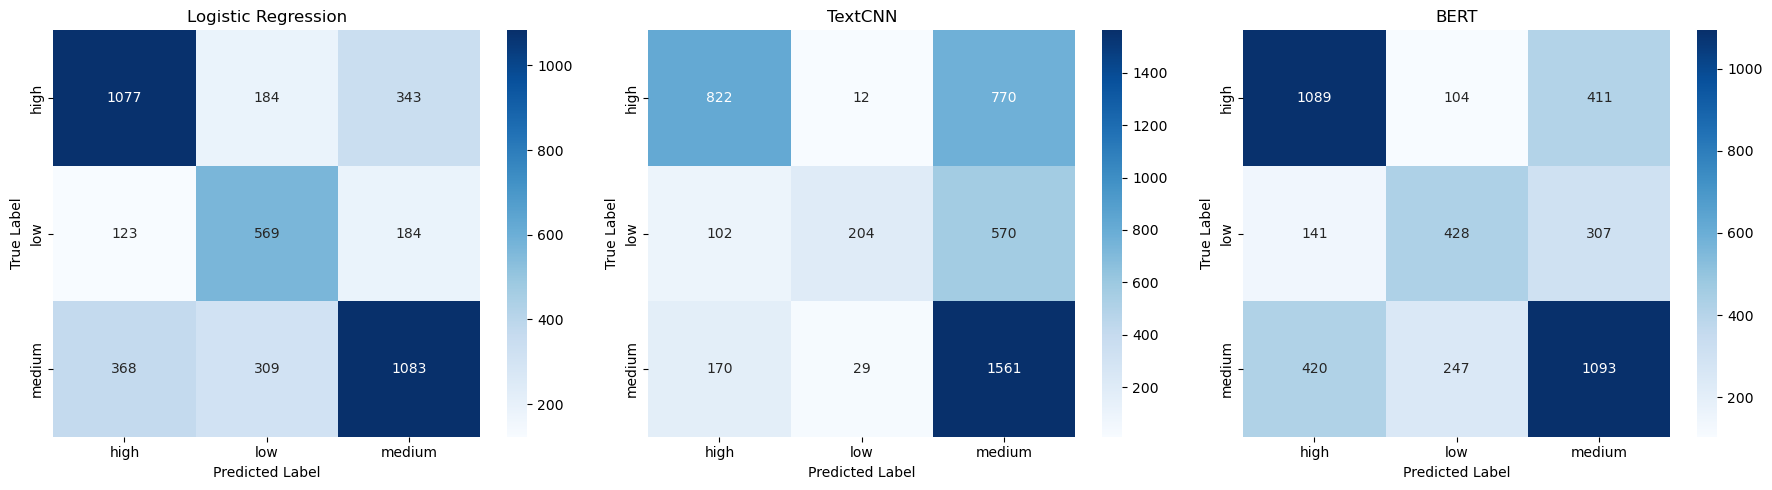

In [ ]:
# Create confusion matrices
label_names = [id2label[i] for i in sorted(id2label.keys())]

cm_logreg = confusion_matrix(test_labels, logreg_pred)
cm_textcnn = confusion_matrix(test_labels, textcnn_pred)
cm_bert = confusion_matrix(test_labels, bert_pred)

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=label_names, yticklabels=label_names)
axes[0].set_title('Logistic Regression')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_textcnn, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=label_names, yticklabels=label_names)
axes[1].set_title('TextCNN')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', ax=axes[2],
            xticklabels=label_names, yticklabels=label_names)
axes[2].set_title('BERT')
axes[2].set_ylabel('True Label')
axes[2].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## 6. Model Comparison Summary

In [ ]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'TextCNN', 'BERT'],
    'Accuracy': [logreg_results['accuracy'], textcnn_results['accuracy'], bert_results['accuracy']],
    'F1 Macro': [logreg_results['f1_macro'], textcnn_results['f1_macro'], bert_results['f1_macro']],
    'F1 Micro': [logreg_results['f1_micro'], textcnn_results['f1_micro'], bert_results['f1_micro']],
    'F1 Weighted': [logreg_results['f1_weighted'], textcnn_results['f1_weighted'], bert_results['f1_weighted']]
})

print("Model Comparison:")
print(comparison_df.to_string(index=False))

Model Comparison:
              Model  Accuracy  F1 Macro  F1 Micro  F1 Weighted
Logistic Regression  0.643632  0.636333  0.643632     0.645004
            TextCNN  0.610142  0.547705  0.610142     0.583746
               BERT  0.615566  0.599568  0.615566     0.614170


## 7. Misclassified Samples Analysis

In [ ]:
# Find misclassified samples for each model
misclassified_logreg = np.where(test_labels != logreg_pred)[0]
misclassified_textcnn = np.where(test_labels != textcnn_pred)[0]
misclassified_bert = np.where(test_labels != bert_pred)[0]

print(f"Misclassified samples:")
print(f"  Logistic Regression: {len(misclassified_logreg)} ({len(misclassified_logreg)/len(test_labels)*100:.2f}%)")
print(f"  TextCNN: {len(misclassified_textcnn)} ({len(misclassified_textcnn)/len(test_labels)*100:.2f}%)")
print(f"  BERT: {len(misclassified_bert)} ({len(misclassified_bert)/len(test_labels)*100:.2f}%)")

# Find samples where all models agree (correct or incorrect)
all_correct = np.where((test_labels == logreg_pred) & 
                       (test_labels == textcnn_pred) & 
                       (test_labels == bert_pred))[0]
all_wrong = np.where((test_labels != logreg_pred) & 
                     (test_labels != textcnn_pred) & 
                     (test_labels != bert_pred))[0]

print(f"\nSamples where all models agree:")
print(f"  All correct: {len(all_correct)}")
print(f"  All wrong: {len(all_wrong)}")

Misclassified samples:
  Logistic Regression: 1511 (35.64%)
  TextCNN: 1653 (38.99%)
  BERT: 1630 (38.44%)

Samples where all models agree:
  All correct: 1592
  All wrong: 642


## 8. Display Misclassified Samples

In [ ]:
# Display some misclassified samples
def display_misclassified_samples(indices, model_name, texts, true_labels, pred_labels, id2label, n_samples=5):
    print(f"\n=== {model_name} - Misclassified Samples ===")
    for i, idx in enumerate(indices[:n_samples]):
        print(f"\nSample {i+1}:")
        print(f"Text: {texts[idx][:200]}...")
        print(f"True Label: {id2label[true_labels[idx]]}")
        print(f"Predicted Label: {id2label[pred_labels[idx]]}")

# Display misclassified samples for each model
display_misclassified_samples(misclassified_logreg, "Logistic Regression", 
                              test_texts, test_labels, logreg_pred, id2label)
display_misclassified_samples(misclassified_textcnn, "TextCNN", 
                              test_texts, test_labels, textcnn_pred, id2label)
display_misclassified_samples(misclassified_bert, "BERT", 
                              test_texts, test_labels, bert_pred, id2label)


=== Logistic Regression - Misclassified Samples ===

Sample 1:
Text: Enhancing Investment Approaches through Data Analytics Technologies

Can you supply comprehensive documentation on best practices for utilizing data analytics tools? Specifically, how to enhance inves...
True Label: high
Predicted Label: low

Sample 2:
Text: Problems with Healthcare Data Accessibility

A healthcare organization faced delays in accessing data. Despite updating the firewall and antivirus software, the problem remains unresolved. We require ...
True Label: medium
Predicted Label: low

Sample 3:
Text: 

Customer support, the hospital's systems have faced data security vulnerabilities, which pose a risk to the confidentiality of medical data. The issue might have originated from outdated configurati...
True Label: medium
Predicted Label: low

Sample 4:
Text: Customer Support Inquiry for QuickBooks Online Integration

Hello, I am interested in integrating QuickBooks Online into my project management SaaS. 

## 9. Agreement Analysis

In [ ]:
# Analyze agreement between models
agreement_matrix = np.zeros((len(test_labels), 3))
agreement_matrix[:, 0] = (test_labels == logreg_pred).astype(int)
agreement_matrix[:, 1] = (test_labels == textcnn_pred).astype(int)
agreement_matrix[:, 2] = (test_labels == bert_pred).astype(int)

# Count agreements
all_agree_correct = np.sum(np.all(agreement_matrix == 1, axis=1))
all_agree_wrong = np.sum(np.all(agreement_matrix == 0, axis=1))
two_agree = len(test_labels) - all_agree_correct - all_agree_wrong

print("Model Agreement Analysis:")
print(f"All three models correct: {all_agree_correct} ({all_agree_correct/len(test_labels)*100:.2f}%)")
print(f"All three models wrong: {all_agree_wrong} ({all_agree_wrong/len(test_labels)*100:.2f}%)")
print(f"Two models agree: {two_agree} ({two_agree/len(test_labels)*100:.2f}%)")

# Find samples where predictions differ
pred_differ = np.where((logreg_pred != textcnn_pred) | 
                       (logreg_pred != bert_pred) | 
                       (textcnn_pred != bert_pred))[0]

print(f"\nSamples where predictions differ: {len(pred_differ)} ({len(pred_differ)/len(test_labels)*100:.2f}%)")

Model Agreement Analysis:
All three models correct: 1592 (37.55%)
All three models wrong: 642 (15.14%)
Two models agree: 2006 (47.31%)

Samples where predictions differ: 2255 (53.18%)


## 10. Per-Class Performance Comparison

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate per-class metrics for each model
precision_logreg, recall_logreg, f1_logreg, _ = precision_recall_fscore_support(
    test_labels, logreg_pred, average=None, labels=[0, 1, 2]
)
precision_textcnn, recall_textcnn, f1_textcnn, _ = precision_recall_fscore_support(
    test_labels, textcnn_pred, average=None, labels=[0, 1, 2]
)
precision_bert, recall_bert, f1_bert, _ = precision_recall_fscore_support(
    test_labels, bert_pred, average=None, labels=[0, 1, 2]
)

# Create comparison dataframe
per_class_df = pd.DataFrame({
    'Class': label_names * 3,
    'Model': ['LogReg'] * 3 + ['TextCNN'] * 3 + ['BERT'] * 3,
    'Precision': list(precision_logreg) + list(precision_textcnn) + list(precision_bert),
    'Recall': list(recall_logreg) + list(recall_textcnn) + list(recall_bert),
    'F1': list(f1_logreg) + list(f1_textcnn) + list(f1_bert)
})

print("Per-Class Performance:")
print(per_class_df.to_string(index=False))

Per-Class Performance:
 Class   Model  Precision   Recall       F1
  high  LogReg   0.686862 0.671446 0.679067
   low  LogReg   0.535782 0.649543 0.587203
medium  LogReg   0.672671 0.615341 0.642730
  high TextCNN   0.751371 0.512469 0.609340
   low TextCNN   0.832653 0.232877 0.363961
medium TextCNN   0.538090 0.886932 0.669813
  high    BERT   0.660000 0.678928 0.669330
   low    BERT   0.549422 0.488584 0.517221
medium    BERT   0.603534 0.621023 0.612153
